In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter 
import datetime as dt
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)
pd.set_option('display.width', 500)


In [2]:
df = pd.read_csv('data/audit-data.csv', keep_default_na=False)
df.head()

,applicant_id,school_name,gpa,degree,location,gender,veteran_status,work_auth,disability,ethnicity,role1,start1,end1,role2,start2,end2,role3,start3,end3,resume_score,prediction,jobref_id,group_idx
0,1,Illinois Institute of Technology,4.00,Master's,43004,F,0,0,0,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,8.91,1,5,1-36001
1,2,Brown University,3.28,Master's,43004,F,0,1,0,White,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5.52,1,5,2-36002
2,3,University of Chicago,3.42,Bachelor's,6520,M,1,1,1,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4.24,1,5,3-36003
3,4,Brown University,2.57,Master's,15213,F,0,0,0,Black,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,9.31,0,5,4-36004
4,5,University of Rhode Island,2.72,PhD,10001,N/A,N/A,1,N/A,Black,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,7.81,0,5,5-36005


In [3]:
def string_to_date(datestr, dt_format="%m/%y"):
    return dt.datetime.strptime(datestr, dt_format)

def date_diff(start_date, end_date):
    return (end_date-start_date).days


def calc_exp(start_str, end_str):
    if pd.isna(start_str) or start_str=="N/A":
        return 0
    else:
        start_dt = string_to_date(start_str)
        
    if pd.isna(end_str) or end_str=="N/A":
        end_dt = dt.datetime.today()
    else:
        end_dt = string_to_date(end_str)
    
    exp = date_diff(start_dt, end_dt)
    return exp

vec_calc_exp = np.vectorize(calc_exp)


df['role1_exp'] = vec_calc_exp(df['start1'], df['end1'])
df['role2_exp'] = vec_calc_exp(df['start2'], df['end2'])
df['role3_exp'] = vec_calc_exp(df['start3'], df['end3'])
df['total_exp'] = (df['role1_exp']+df['role2_exp']+df['role3_exp'])//365
df['num_jobs'] = np.sum(df[['role1_exp','role2_exp','role3_exp']].values>0, axis=1)
df['exp_cat'] = pd.cut(df['total_exp'], bins=[0,1,3,5,10,15,100], 
                       labels=['00-01','01-03','03-05','05-10','10-15','15+'],
                       include_lowest=True, right=False)

df.groupby(['exp_cat','num_jobs']).agg({'applicant_id':'count'}).pivot_table(
    index=['num_jobs'],columns=['exp_cat'])


applicant_id                               
exp_cat         00-01 01-03 03-05  05-10 10-15   15+
num_jobs                                            
0                3280     0     0      0     0     0
1                   0  6800  3320      0     0     0
2                   0  3520  3340      0     0     0
3                   0     0  3120  10160  3510  2950

In [4]:
# show the distribution of ethnicity and gender and do not show the column names
df.groupby(['gender', 'ethnicity']).size().unstack()

ethnicity,Asian,Black,Native American,Pacific Islander,White
gender,,,,,
F,2780,2830,2650,2890,2610
M,2480,2780,2670,2620,2520
N/A,2710,2650,2500,2640,2670


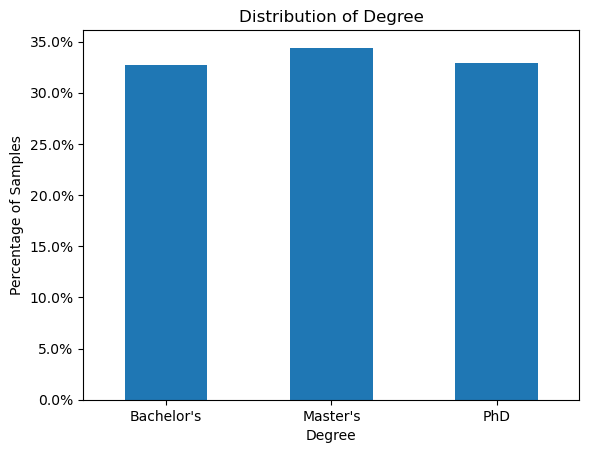

In [5]:
# create bar plot for degree in percentage
degree = ['Bachelors', 'Master\'s', 'PhD']

temp_df_degree = df.groupby(by='degree').size()/df.groupby(by='degree').size().sum()
temp_df_degree.plot(kind='bar')

# rotate the x-axis labels
plt.xticks(rotation=0)

# add title and labels
plt.title('Distribution of Degree')
plt.xlabel('Degree')
plt.ylabel('Percentage of Samples')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# save as png
plt.savefig('plots/degree-dist.png', dpi=300)


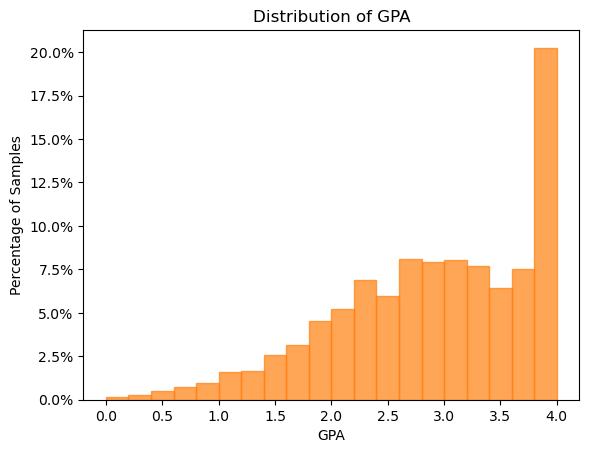

In [6]:
# show the distribution of GPA density in a histogram, remove grid and add n_bins
plt.hist(df['gpa'], weights=np.ones(len(df['gpa'])) / len(df['gpa']), color='tab:orange', alpha=0.7, edgecolor='tab:orange', bins=20)

# plt.hist(kind='hist', density=True, grid=False, bins=11)

# # add title and labels
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.ylabel('Percentage of Samples')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# # save as png
plt.savefig('plots/gpa-dist.png', dpi=300)

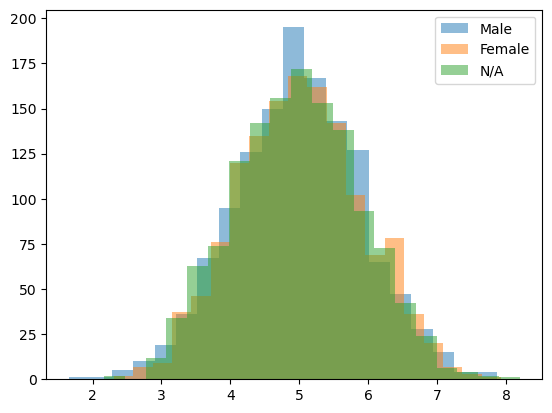

In [7]:
# show the distribution of mean resume score for each group_idx in a histogram, remove grid and add n_bins
n_bins = 20

plt.hist(df[df['gender']=='M'].groupby(['group_idx'])['resume_score'].mean(), n_bins, alpha=0.5, label='Male')
plt.hist(df[df['gender']=='F'].groupby(['group_idx'])['resume_score'].mean(), n_bins, alpha=0.5, label='Female')
plt.hist(df[df['gender']=='N/A'].groupby(['group_idx'])['resume_score'].mean(), n_bins, alpha=0.5, label='N/A')

plt.legend(loc='upper right')
plt.show()
